In [1]:
import pandas as pd
from supabase import create_client, Client
import os
import matplotlib.pyplot as plt

supabase_url = os.getenv('SUPABASE_URL')
supabase_key = os.getenv('SUPABASE_KEY') 

url: str = supabase_url
key: str = supabase_key

supabase: Client = create_client(url, key)

response = supabase.table('produtosKabum').select('*').execute()

df = pd.DataFrame(response.data)

df.head(3)

,id,data,id_kabum,categoria,subcategoria,nome,preco,preco_pix,descricao,openbox,imagem,site,url
0,264,2024-06-19T19:41:29.3192+00:00,128250,Hardware,Disco Rígido (HD),"HD Seagate IronWolf NAS, 14TB, 3.5´, SATA - ST...",3294.11,2799.99,Compre HD Seagate IronWolf NAS no KaBuM! As me...,0,,kabum,https://www.kabum.com.br/produto/128250
1,265,2024-06-19T19:41:29.432631+00:00,100916,Hardware,Disco Rígido (HD),"HD Seagate 2TB BarraCuda, 3.5', SATA - ST2000D...",494.11,419.99,"Um desempenho robusto e confiabilidade, Cache ...",0,https://images.kabum.com.br/produtos/fotos/100...,kabum,https://www.kabum.com.br/produto/100916
2,266,2024-06-19T19:41:29.517339+00:00,95803,Hardware,Disco Rígido (HD),"HD Seagate 4TB BarraCuda, 3.5', SATA - ST4000D...",823.52,699.99,O HD perfeito para armazenamento de todos os s...,0,https://images.kabum.com.br/produtos/fotos/958...,kabum,https://www.kabum.com.br/produto/95803


In [2]:
# tipos de categorias
categorias = df['categoria'].unique()
print(categorias)

# tipos de subcategorias
subcategorias = df['subcategoria'].unique()
print(subcategorias)

['Hardware' 'Computadores']
['Disco Rígido (HD)' 'Memória RAM' 'Placa de vídeo (VGA)' 'Placas-mãe'
 'SSD' 'Coolers' 'Processadores' 'Fontes' 'Notebooks']


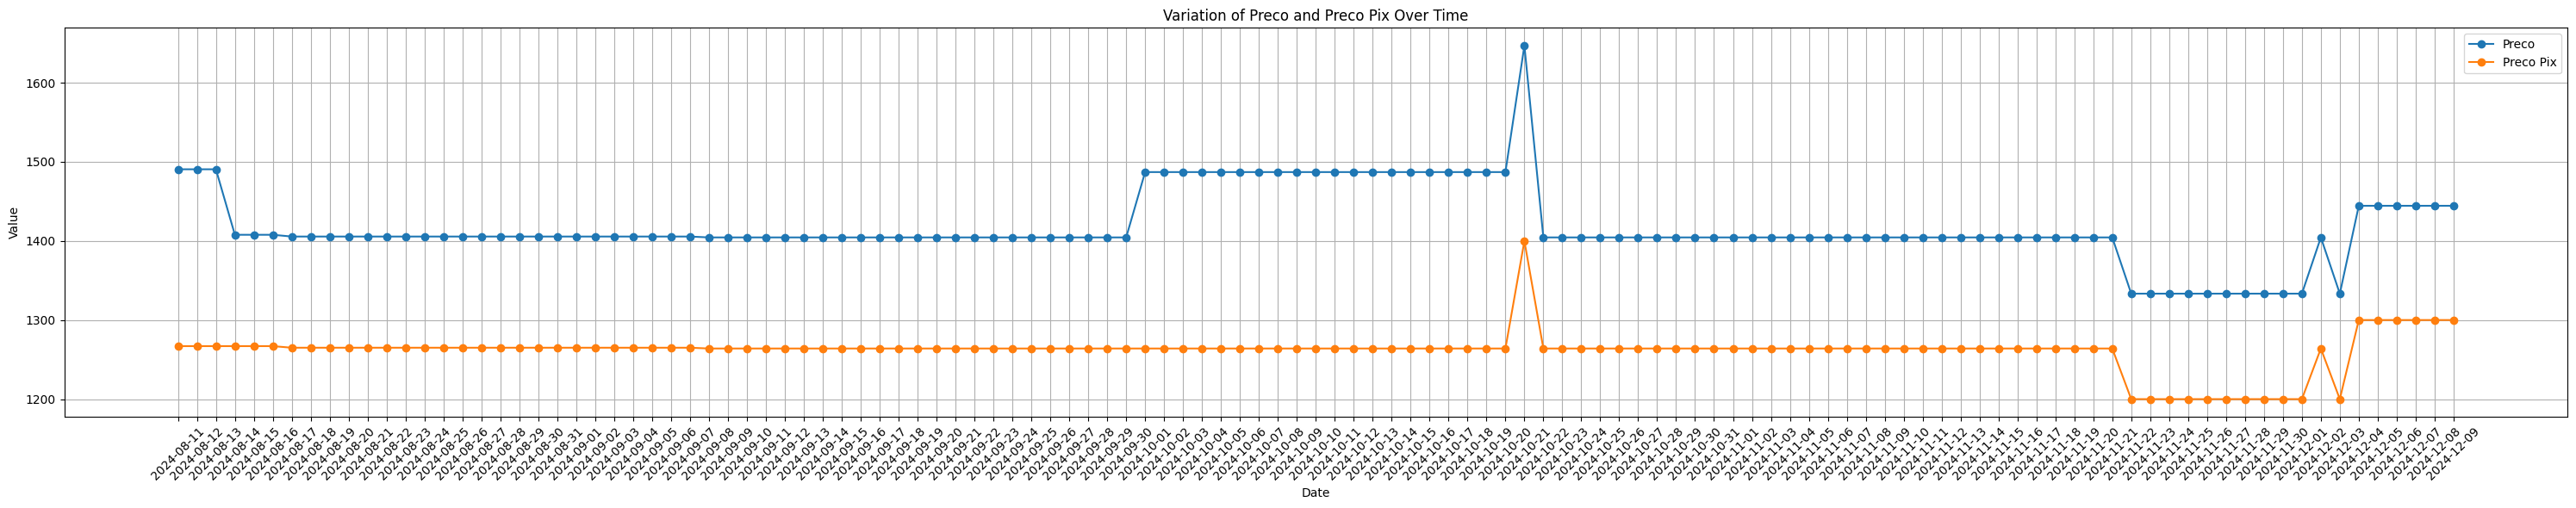

In [3]:
# Seleção do produto e criação de uma cópia para evitar o SettingWithCopyWarning
produto_selecionado = df[df['id_kabum'] == 520365].copy()

# Converter a coluna 'data' para datetime
produto_selecionado['data'] = pd.to_datetime(produto_selecionado['data'])

# Extrair a data sem a parte do tempo
produto_selecionado['data_somente'] = produto_selecionado['data'].dt.date

# Remover duplicatas com base na coluna 'data_somente'
df_sem_duplicatas = produto_selecionado.drop_duplicates(subset='data_somente')

# Ordenar o DataFrame pela coluna 'data_somente' em ordem crescente
df_ordenado = df_sem_duplicatas.sort_values(by='data_somente', ascending=True)

# Preencher as datas ausentes no DataFrame
# Criar uma série de datas completas no intervalo
data_inicial = df_ordenado['data_somente'].min()
data_final = df_ordenado['data_somente'].max()
todas_as_datas = pd.date_range(data_inicial, data_final).date

# Criar um DataFrame com todas as datas
df_completo = pd.DataFrame({'data_somente': todas_as_datas})

# Mesclar com o DataFrame original para adicionar as datas ausentes
df_completo = df_completo.merge(df_ordenado, on='data_somente', how='left')

# Preencher os valores ausentes de preço com o preço do dia anterior
df_completo['preco'] = df_completo['preco'].ffill()
df_completo['preco_pix'] = df_completo['preco_pix'].ffill()

# Configuração do gráfico
plt.figure(figsize=(30, 6))

# Plotando 'preco'
plt.plot(df_completo['data_somente'], df_completo['preco'], label='Preco', marker='o')

# Plotando 'preco_pix'
plt.plot(df_completo['data_somente'], df_completo['preco_pix'], label='Preco Pix', marker='o')

# Adicionando título e rótulos
plt.title('Variation of Preco and Preco Pix Over Time')
plt.xlabel('Date')
plt.ylabel('Value')

# Adicionando uma legenda
plt.legend()

# Rotação dos rótulos para melhor legibilidade
plt.xticks(rotation=45)

# Configuração explícita dos rótulos do eixo x
plt.xticks(df_completo['data_somente'], df_completo['data_somente'].astype(str), rotation=45)

# Mostrar o gráfico
plt.grid(True)
plt.tight_layout()
plt.show()


In [4]:
from datetime import date

# Seleção do produto e criação de uma cópia
produto_selecionado = df[df['id_kabum'] == 520365].copy()

# Converter a coluna 'data' para datetime
produto_selecionado['data'] = pd.to_datetime(produto_selecionado['data'])

# Extrair a data sem a parte do tempo
produto_selecionado['data_somente'] = produto_selecionado['data'].dt.date

# Remover duplicatas com base na coluna 'data_somente'
df_sem_duplicatas = produto_selecionado.drop_duplicates(subset='data_somente')

# Ordenar o DataFrame pela coluna 'data_somente' em ordem crescente
df_ordenado = df_sem_duplicatas.sort_values(by='data_somente', ascending=True)

# Identificar o menor preço registrado
menor_preco = df_ordenado['preco'].min()

# Identificar o maior preço registrado
maior_preco = df_ordenado['preco'].max()

# Obter o preço do dia atual (se houver registro)
data_hoje = date.today()
preco_hoje = df_ordenado.loc[df_ordenado['data_somente'] == data_hoje, 'preco'].iloc[0] if data_hoje in df_ordenado['data_somente'].values else None

# Exibir os resultados
print(f"Menor preço registrado: {menor_preco}")
print(f"Maior preço registrado: {maior_preco}")
print(f"Preço no dia de hoje: {preco_hoje}")


Menor preço registrado: 1333.32
Maior preço registrado: 1647.05
Preço no dia de hoje: 1444.43


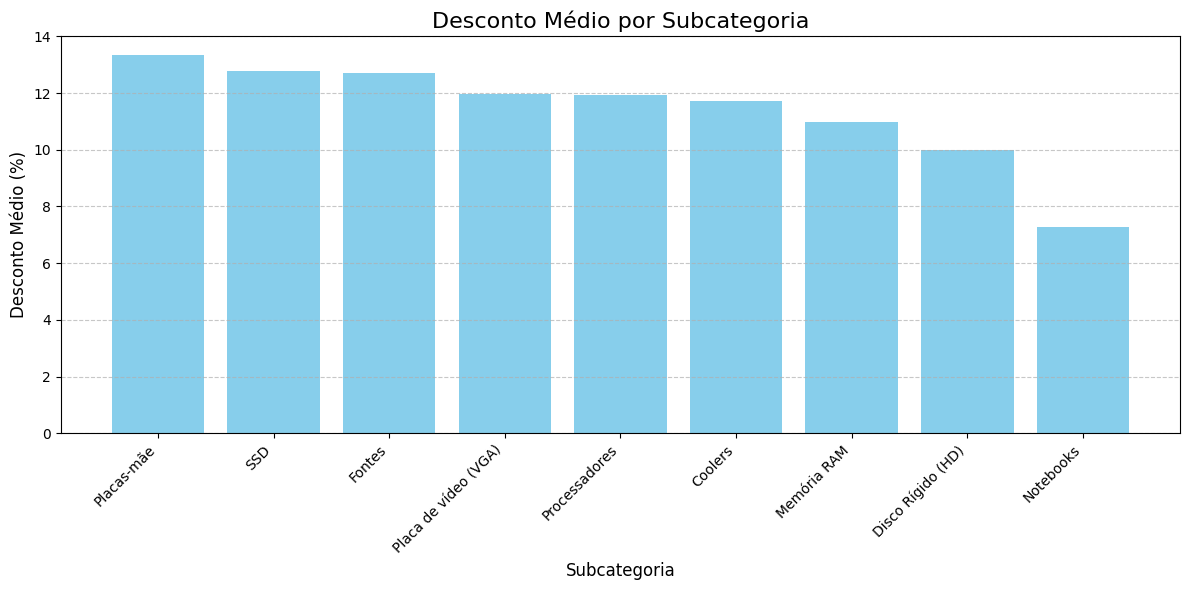

In [5]:
# Calcular o desconto para cada produto
df['desconto'] = ((df['preco'] - df['preco_pix']) / df['preco']) * 100

# Calcular o desconto médio por subcategoria
desconto_subcategoria = df.groupby('subcategoria')['desconto'].mean().reset_index()

# Ordenar subcategorias por desconto médio em ordem decrescente
desconto_subcategoria = desconto_subcategoria.sort_values(by='desconto', ascending=False)

# Criar o gráfico de barras
plt.figure(figsize=(12, 6))
plt.bar(desconto_subcategoria['subcategoria'], desconto_subcategoria['desconto'], color='skyblue')

# Adicionar rótulos e título
plt.title('Desconto Médio por Subcategoria', fontsize=16)
plt.xlabel('Subcategoria', fontsize=12)
plt.ylabel('Desconto Médio (%)', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Exibir o gráfico
plt.tight_layout()
plt.show()
